In [27]:
import os
import datetime

import IPython
import IPython.display

from confluent_kafka import avro, Consumer, KafkaError, KafkaException
from confluent_kafka.avro import CachedSchemaRegistryClient
from confluent_kafka.avro.serializer.message_serializer import MessageSerializer as AvroSerde

import json
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [ ]:
schema_registry = CachedSchemaRegistryClient(os.getenv("SCHEMA_REGISTRY"))
avro_serde = AvroSerde(schema_registry)
deserialize_avro = avro_serde.decode_message

In [ ]:
def create_client():    

    consumer_config = {"bootstrap.servers": os.getenv("BOOTSTRAP_SERVERS"),                        
                        "group.id": "sami-local-test-6",
                        "max.poll.interval.ms": 30000,
                        "session.timeout.ms": 20000,
                        "default.topic.config": {"auto.offset.reset": "earliest"},
                        "security.protocol": "SSL",
                        "ssl.ca.location": "../tms-secrets/processing/ca.pem",
                        "ssl.certificate.location": "../tms-secrets/processing/service.cert",
                        "ssl.key.location": "../tms-secrets/processing/service.key"
                       }

    return Consumer(consumer_config)  

In [ ]:
training_dict = []
def consume_records():
    client = create_client()
    client.subscribe(["observations.weather.multivariate"])
    i = 0
    for i in tqdm(range(200000)):
        msg = client.poll(1)
        if msg is None: continue
        
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                # End of partition event
                sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                 (msg.topic(), msg.partition(), msg.offset()))
            elif msg.error():
                raise KafkaException(msg.error())
        else:
            value = deserialize_avro(message=msg.value(), is_key=False)
            training_dict.append(value)
            pass
    client.close()

In [ ]:
# Training set from Kafka
consume_records()
df = pd.json_normalize(training_dict)
df['measuredTime'] = pd.to_datetime(df['measuredTime'] * 1000 * 1000)


In [ ]:
columns = ['roadStationId', 'measuredTime','measurements.1', 'measurements.16', 'measurements.17', 'measurements.18', 'measurements.19', 'measurements.21']
df2 = df[columns]
df2.index = df2['measuredTime']
del df2['measuredTime']
df2.info()

In [ ]:
interpo = df2.groupby('roadStationId').resample('600s').mean().interpolate()
del interpo['roadStationId']
len(interpo.index.unique(level='roadStationId'))
interpo = interpo.dropna()
interpo = interpo.iloc[interpo.index.get_level_values(0) == 2052]

In [138]:
# Training set from history file
df = pd.read_csv('vantaa-2017-2020.csv')
df['time'] = pd.to_datetime(df[['Pv','Kk','Vuosi', 'Klo']]
                   .astype(str).apply(' '.join, 1), format='%d %m %Y %H:%M')
df.drop(columns=['Pv','Kk','Vuosi', 'Klo', 'Aikavyöhyke'], inplace=True)
df.index = df['time']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213965 entries, 2017-01-01 00:00:00 to 2021-02-09 00:00:00
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Ilmanpaine (msl) (hPa)    212924 non-null  float64       
 1   Suhteellinen kosteus (%)  212917 non-null  float64       
 2   Ilman lämpötila (degC)    212913 non-null  float64       
 3   Tuulen suunta (deg)       212272 non-null  float64       
 4   Puuskanopeus (m/s)        212264 non-null  float64       
 5   Tuulen nopeus (m/s)       212248 non-null  float64       
 6   time                      213965 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.1 MB


In [139]:
interpo = df.resample('600s').mean().interpolate()
interpo = interpo[5::6]
interpo.describe()

,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Ilman lämpötila (degC),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
count,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,1011.970055,80.079548,6.604001,192.271494,6.353747,4.510833
std,11.573468,19.674819,8.972406,99.054235,3.167101,2.185026
min,963.600000,16.000000,-25.300000,0.000000,0.300000,0.000000
25%,1004.900000,68.000000,0.300000,116.000000,4.000000,2.900000
50%,1012.300000,87.000000,5.300000,205.000000,5.900000,4.200000
75%,1019.600000,96.000000,13.700000,272.000000,8.200000,5.800000
max,1049.600000,100.000000,32.400000,360.000000,22.500000,16.400000


In [140]:
wind_direction = interpo['Tuulen suunta (deg)']
wind_v = interpo['Tuulen nopeus (m/s)']
wind_v_max = interpo['Puuskanopeus (m/s)']

Text(0, 0.5, 'Wind Velocity [m/s]')

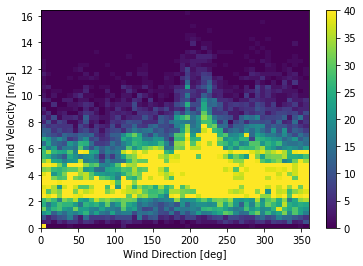

In [141]:
plt.hist2d(wind_direction, wind_v, bins=(50, 50), vmax=40)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [142]:
# Convert to wind vector
wv = interpo.pop('Tuulen nopeus (m/s)')
max_wv = interpo.pop('Puuskanopeus (m/s)')

# Convert to radians.
wd_rad = interpo.pop('Tuulen suunta (deg)')*np.pi / 180

# Calculate the wind x and y components.
interpo['Wx'] = wv*np.cos(wd_rad)
interpo['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
interpo['max Wx'] = max_wv*np.cos(wd_rad)
interpo['max Wy'] = max_wv*np.sin(wd_rad)

(-15.310718994554106,
 13.3882665834825,
 -14.030928932907388,
 12.718853254308373)

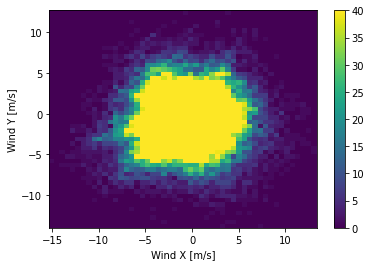

In [143]:
plt.hist2d(interpo['Wx'], interpo['Wy'], bins=(50, 50), vmax=40)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

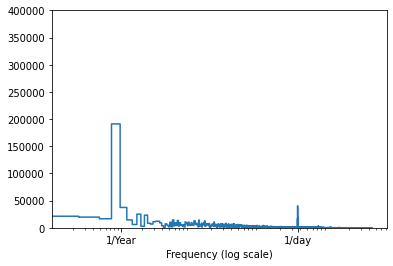

In [145]:
fft = tf.signal.rfft(interpo['Ilman lämpötila (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(interpo['Ilman lämpötila (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [146]:
day = 24*60*60
year = (365.2425)*day
date_time = interpo.index.get_level_values('time')

In [147]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
interpo['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
interpo['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
interpo['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
interpo['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

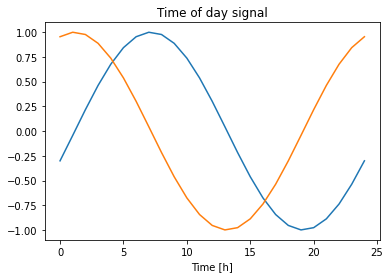

In [148]:
plt.plot(np.array(interpo['Day sin'])[:25])
plt.plot(np.array(interpo['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [149]:
# Split dataset
column_indices = {name: i for i, name in enumerate(interpo.columns)}

n = len(interpo)
train_df = interpo[0:int(n*0.7)]
val_df = interpo[int(n*0.7):int(n*0.9)]
test_df = interpo[int(n*0.9):]

num_features = interpo.shape[1]

In [150]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [151]:
df_std = (interpo - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

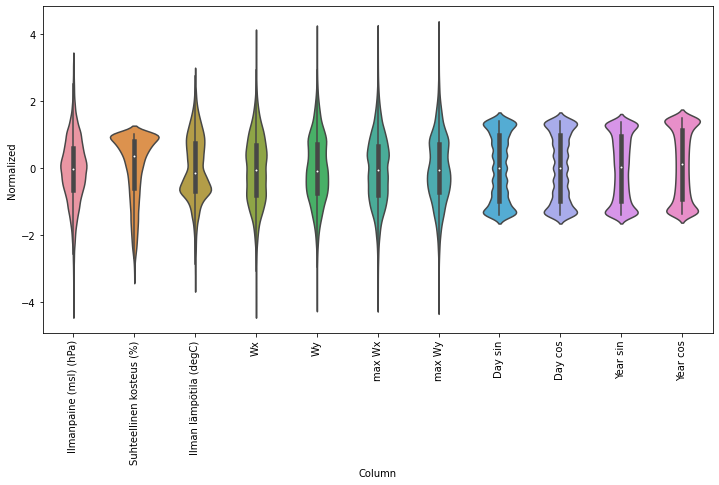

In [152]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(interpo.keys(), rotation=90)

In [153]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [154]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Ilman lämpötila (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Ilman lämpötila (degC)']

In [155]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Ilman lämpötila (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Ilman lämpötila (degC)']

In [156]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [157]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 11)
Inputs shape: (3, 6, 11)
labels shape: (3, 1, 1)


In [158]:
w2.example = example_inputs, example_labels

In [159]:
def plot(self, model=None, plot_col='Ilman lämpötila (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

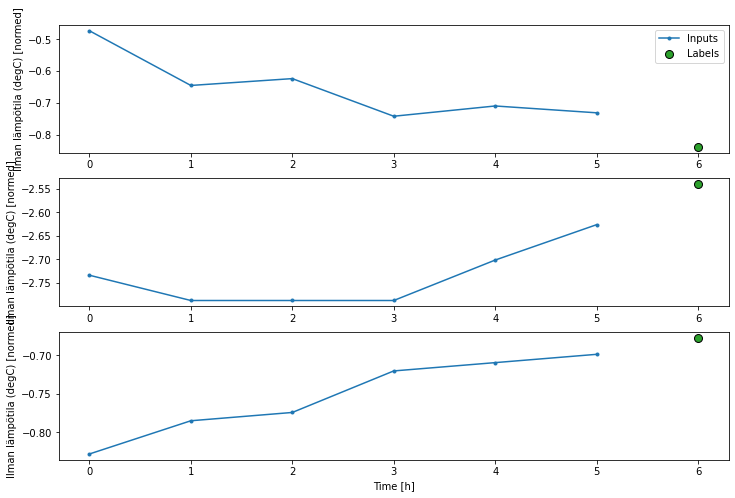

In [160]:
w2.plot()

In [161]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [162]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [163]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [164]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 11)
Labels shape (batch, time, features): (32, 1, 1)


In [165]:
# Multi step models
val_performance = {}
performance = {}

In [166]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

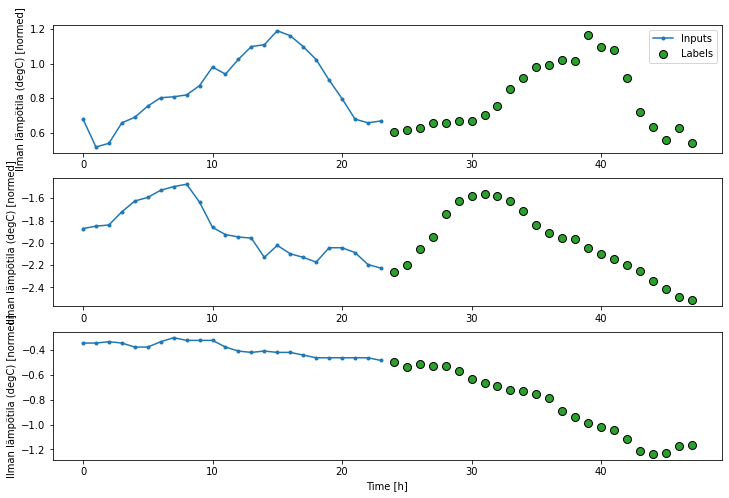

In [167]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

224/224 [==============================] - 0s 1ms/step - loss: 0.7999 - mean_absolute_error: 0.5773


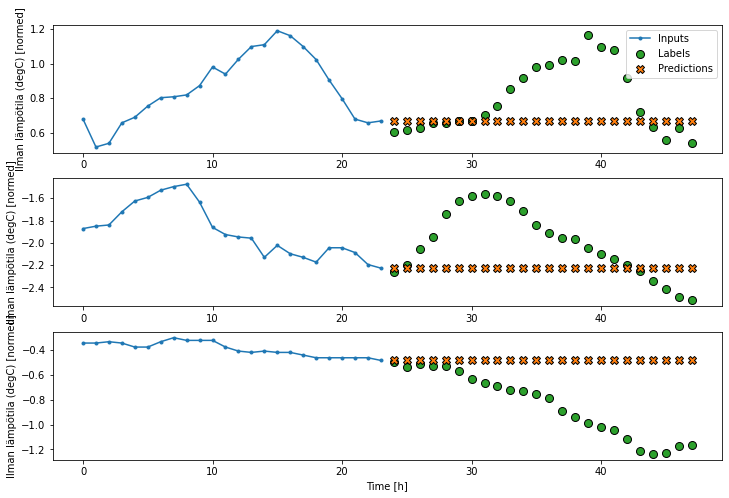

In [168]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

224/224 [==============================] - 0s 1ms/step - loss: 0.5988 - mean_absolute_error: 0.4435


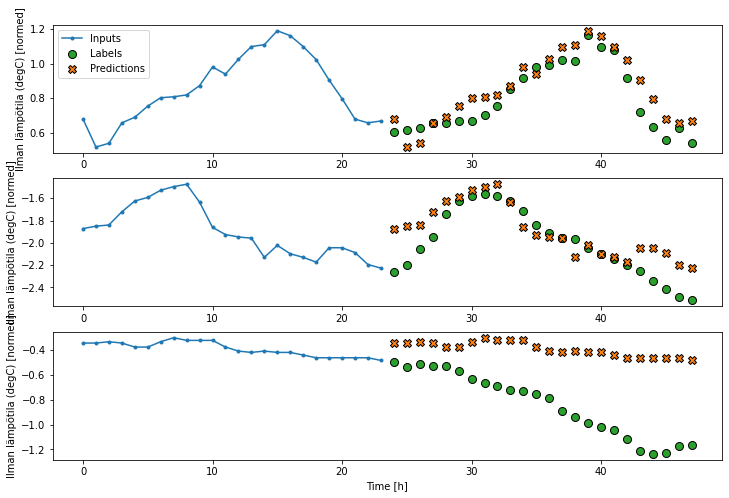

In [169]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

224/224 [==============================] - 0s 1ms/step - loss: 0.3027 - mean_absolute_error: 0.3162


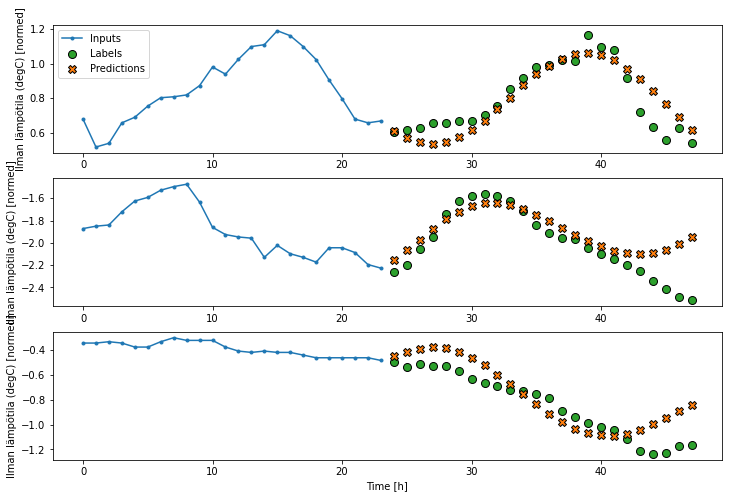

In [170]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

224/224 [==============================] - 1s 2ms/step - loss: 0.2879 - mean_absolute_error: 0.3268


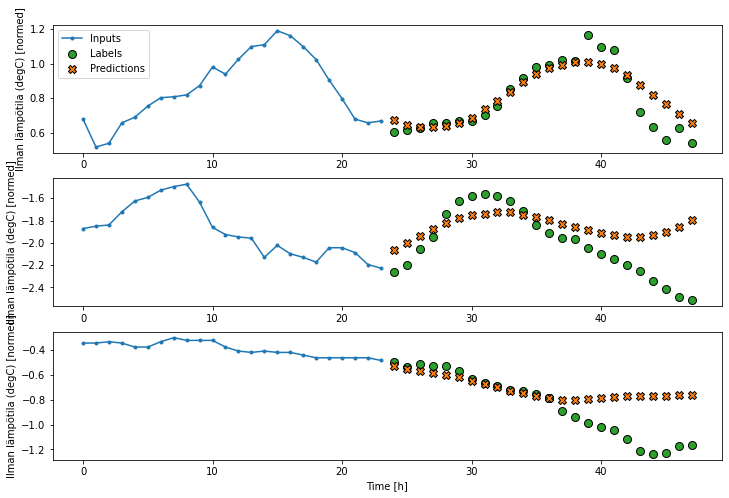

In [171]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [172]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [173]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [174]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [175]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 11])

In [176]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

224/224 [==============================] - 1s 3ms/step - loss: 0.3187 - mean_absolute_error: 0.3497


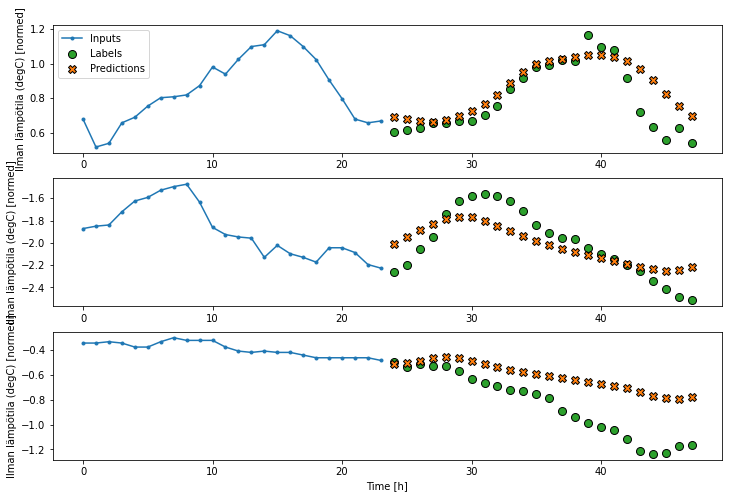

In [177]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

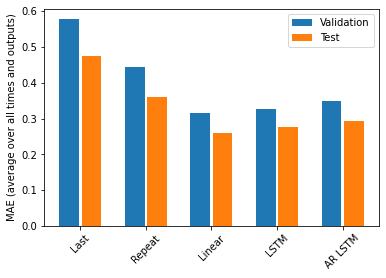

In [178]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()